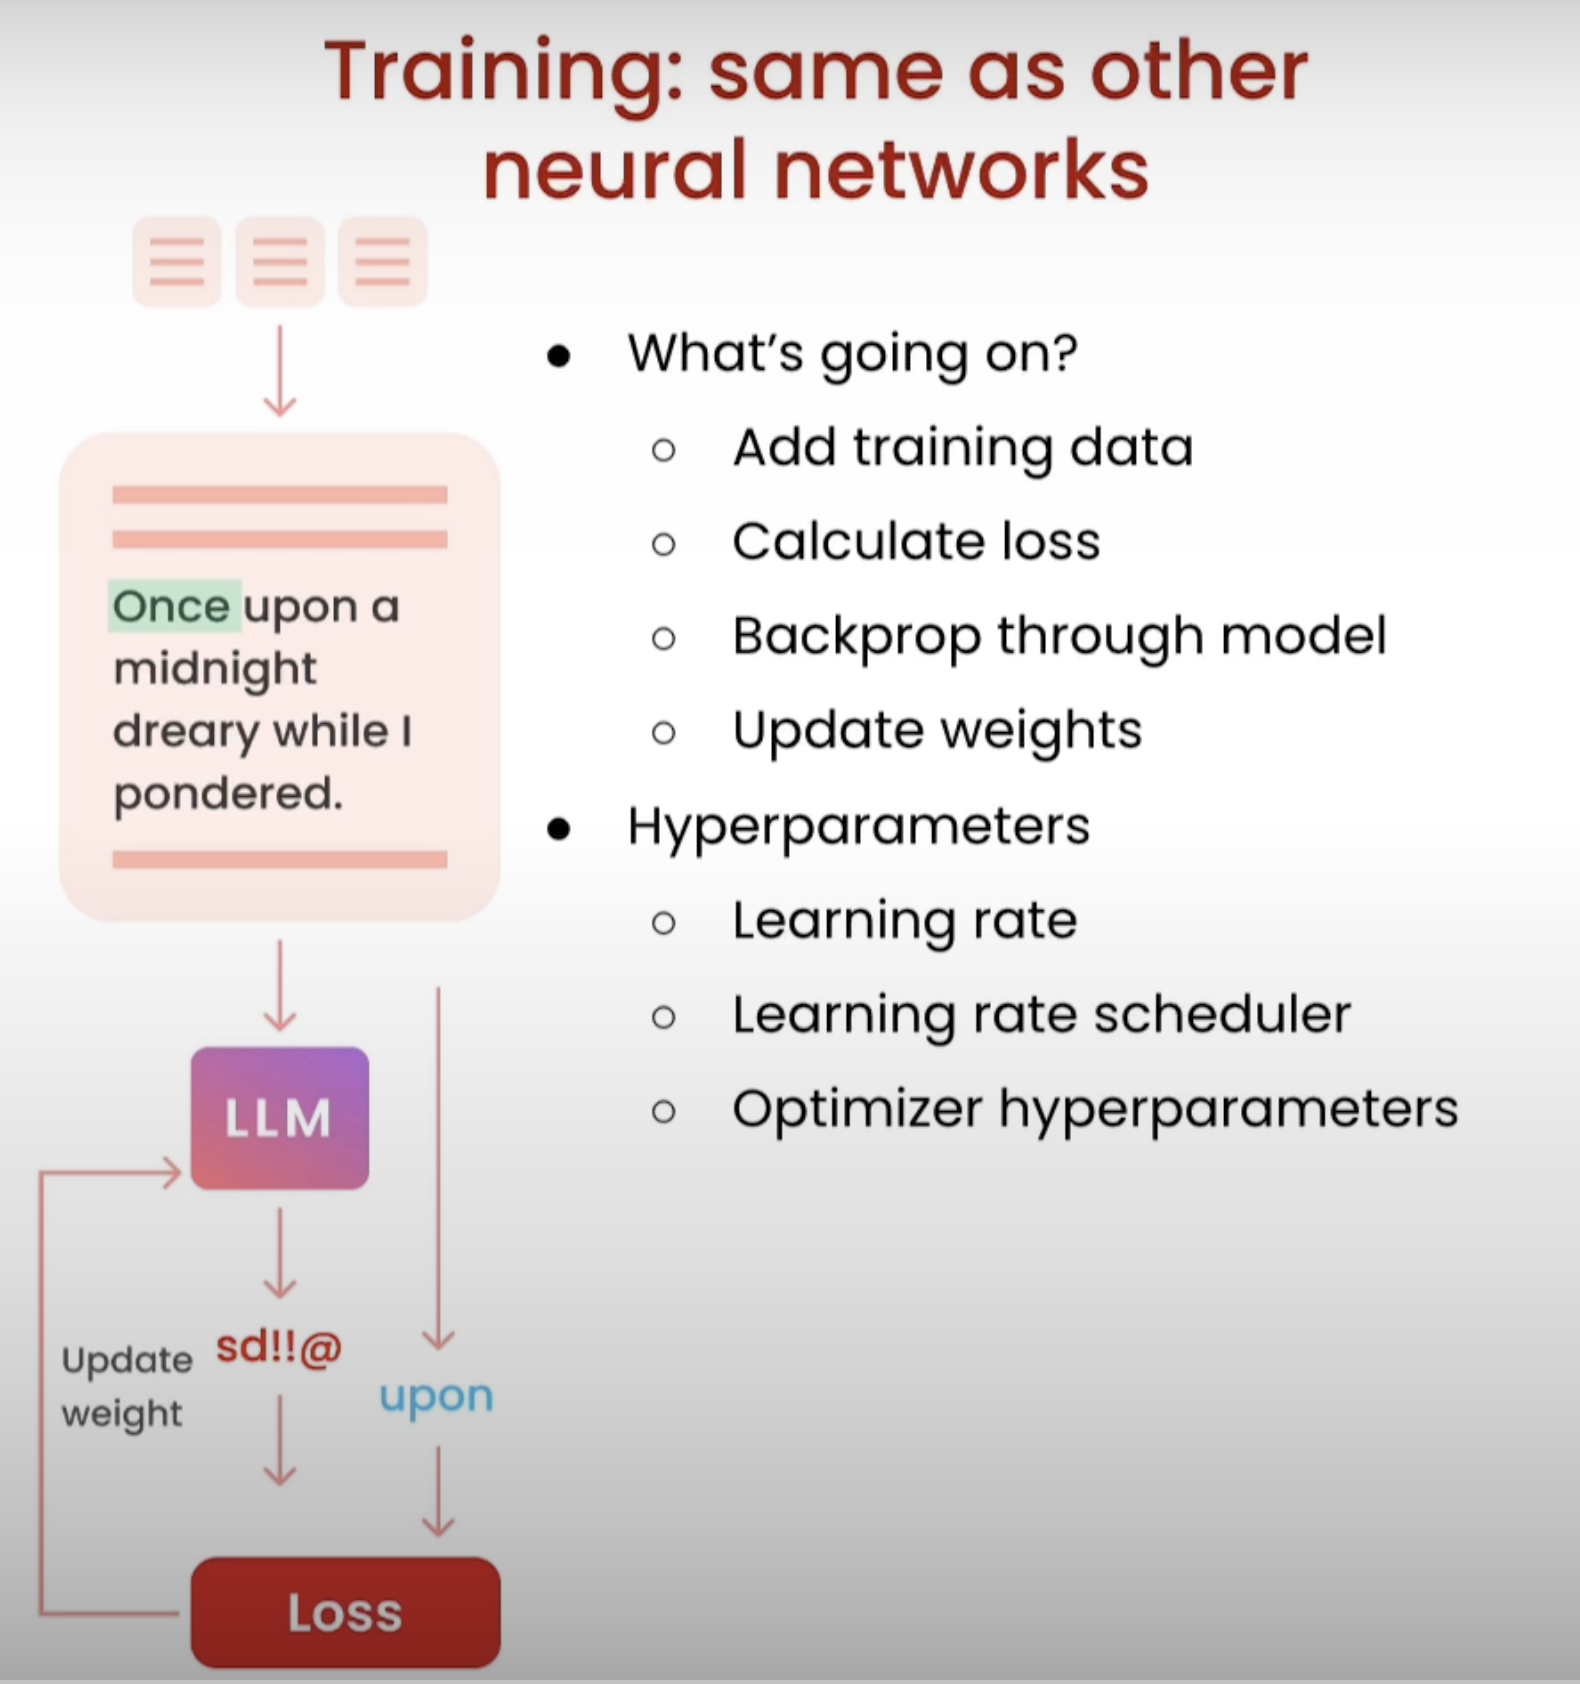
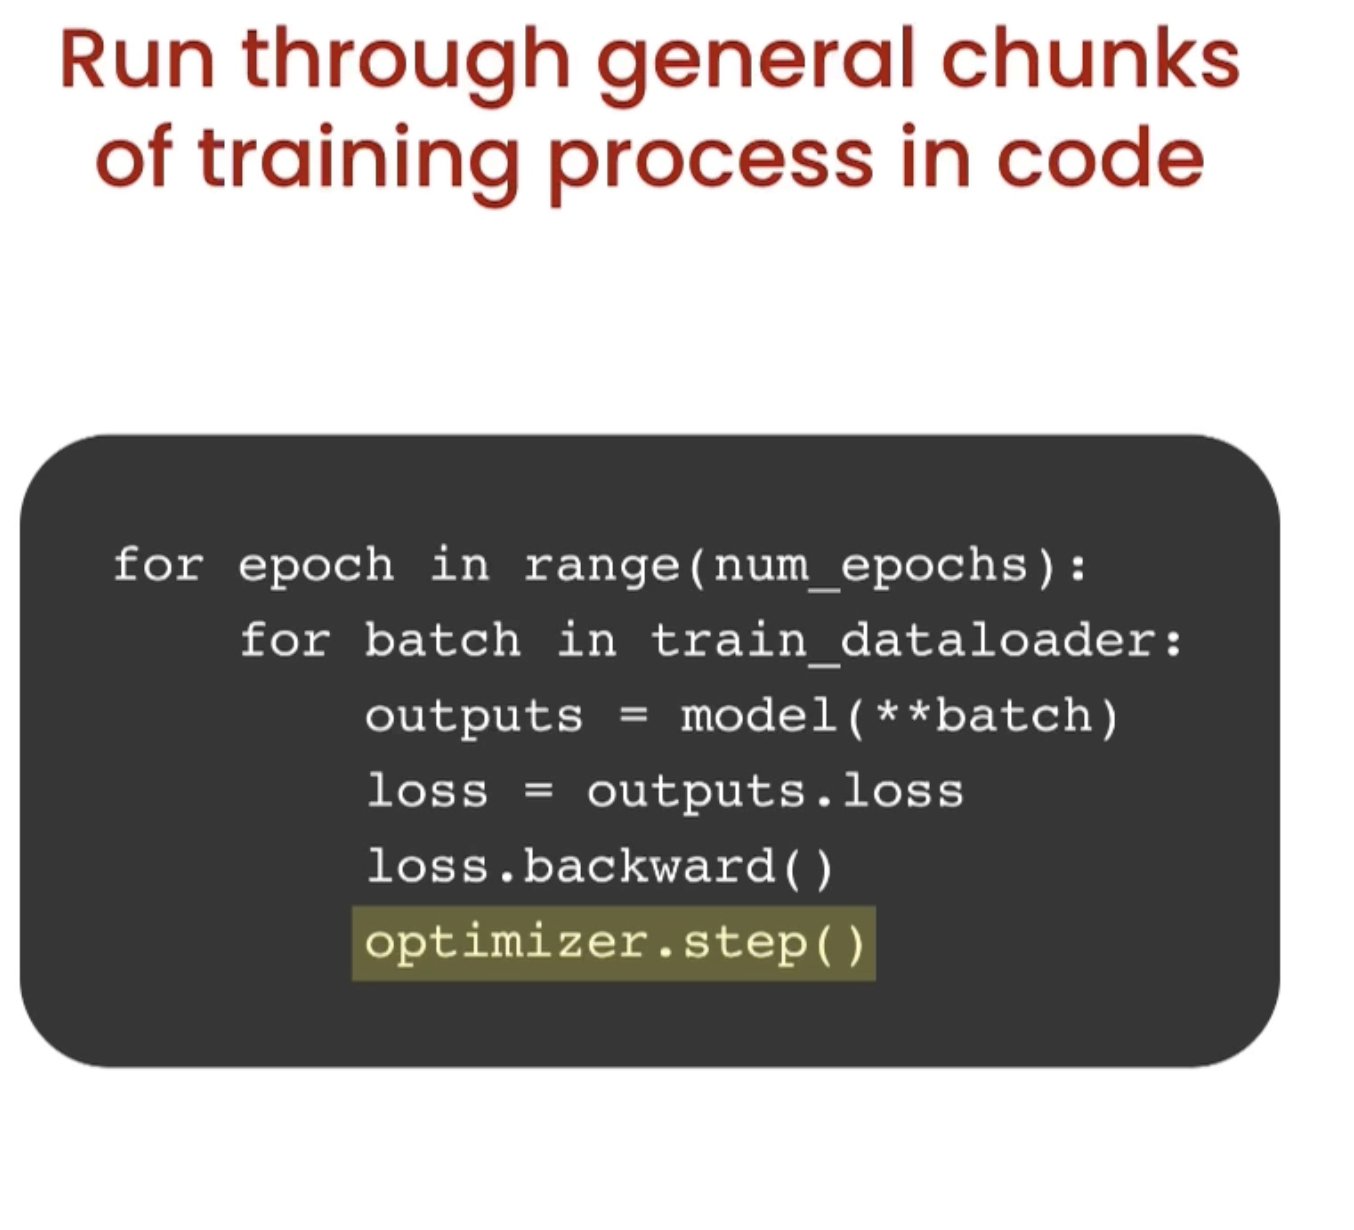

# Training

## Technically, it's only a few lines of code to run on GPUs (elsewhere, ie. on Lamini).
```
from llama import BasicModelRunner

model = BasicModelRunner("EleutherAI/pythia-410m") 
model.load_data_from_jsonlines("lamini_docs.jsonl", input_key="question", output_key="answer")
model.train(is_public=True) 


```
1. Choose base model.
2. Load data.
3. Train it. Returns a model ID, dashboard, and playground interface.

### Let's look under the hood at the core code running this! This is the open core of Lamini's `llama` library :)

In [1]:
import os
import lamini

lamini.api_url = os.getenv("POWERML__PRODUCTION__URL")
lamini.api_key = os.getenv("POWERML__PRODUCTION__KEY")

In [2]:
import datasets
import tempfile
import logging
import random
import config
import os
import yaml
import time
import torch
import transformers
import pandas as pd
import jsonlines

from utilities import *
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
from transformers import TrainingArguments
from transformers import AutoModelForCausalLM
from llama import BasicModelRunner



logger = logging.getLogger(__name__)
global_config = None

/Users/itz_time_to_work/Study/GenAI-Practice/.venv-studies/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the Lamini docs dataset

In [3]:
dataset_name = "lamini_docs.jsonl"
dataset_path = f"/content/{dataset_name}"
use_hf = False

In [4]:
dataset_path = "lamini/lamini_docs"
use_hf = True

### Set up the model, training config, and tokenizer

In [5]:
model_name = "EleutherAI/pythia-70m"

In [6]:
training_config = {
    "model": {
        "pretrained_name": model_name,
        "max_length" : 2048
    },
    "datasets": {
        "use_hf": use_hf,
        "path": dataset_path
    },
    "verbose": True
}

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
train_dataset, test_dataset = tokenize_and_split_data(training_config, tokenizer)

print(train_dataset)
print(test_dataset)

2025-11-13 16:23:38,135 - DEBUG - utilities - Config: datasets.path: lamini/lamini_docs
datasets.use_hf: true
model.max_length: 2048
model.pretrained_name: EleutherAI/pythia-70m
verbose: true



tokenize True lamini/lamini_docs


2025-11-13 16:23:39,457 - DEBUG - fsspec.local - open file: /Users/itz_time_to_work/.cache/huggingface/datasets/lamini___lamini_docs/default/0.0.0/05bd680b81d69a7a1d38193873f1487d73e535bf/dataset_info.json
2025-11-13 16:23:39,500 - DEBUG - fsspec.local - open file: /Users/itz_time_to_work/.cache/huggingface/datasets/lamini___lamini_docs/default/0.0.0/05bd680b81d69a7a1d38193873f1487d73e535bf/dataset_info.json


Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1260
})
Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 140
})


: 

### Load the base model

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(model_name)

In [ ]:
device_count = torch.cuda.device_count()
if device_count > 0:
    logger.debug("Select GPU device")
    device = torch.device("cuda")
else:
    logger.debug("Select CPU device")
    device = torch.device("cpu")

In [ ]:
base_model.to(device)

### Define function to carry out inference

In [ ]:
def inference(text, model, tokenizer, max_input_tokens=1000, max_output_tokens=100):
  # Tokenize
  input_ids = tokenizer.encode(
          text,
          return_tensors="pt",
          truncation=True,
          max_length=max_input_tokens
  )

  # Generate
  device = model.device
  generated_tokens_with_prompt = model.generate(
    input_ids=input_ids.to(device),
    max_length=max_output_tokens
  )

  # Decode
  generated_text_with_prompt = tokenizer.batch_decode(generated_tokens_with_prompt, skip_special_tokens=True)

  # Strip the prompt
  generated_text_answer = generated_text_with_prompt[0][len(text):]

  return generated_text_answer

### Try the base model

In [ ]:
test_text = test_dataset[0]['question']
print("Question input (test):", test_text)
print(f"Correct answer from Lamini docs: {test_dataset[0]['answer']}")
print("Model's answer: ")
print(inference(test_text, base_model, tokenizer))

### Setup training

In [ ]:
max_steps = 3

In [ ]:
trained_model_name = f"lamini_docs_{max_steps}_steps"
output_dir = trained_model_name

In [ ]:
training_args = TrainingArguments(

  # Learning rate
  learning_rate=1.0e-5,

  # Number of training epochs
  num_train_epochs=1,

  # Max steps to train for (each step is a batch of data)
  # Overrides num_train_epochs, if not -1
  max_steps=max_steps,

  # Batch size for training
  per_device_train_batch_size=1,

  # Directory to save model checkpoints
  output_dir=output_dir,

  # Other arguments
  overwrite_output_dir=False, # Overwrite the content of the output directory
  disable_tqdm=False, # Disable progress bars
  eval_steps=120, # Number of update steps between two evaluations
  save_steps=120, # After # steps model is saved
  warmup_steps=1, # Number of warmup steps for learning rate scheduler
  per_device_eval_batch_size=1, # Batch size for evaluation
  evaluation_strategy="steps",
  logging_strategy="steps",
  logging_steps=1,
  optim="adafactor",
  gradient_accumulation_steps = 4,
  gradient_checkpointing=False,

  # Parameters for early stopping
  load_best_model_at_end=True,
  save_total_limit=1,
  metric_for_best_model="eval_loss",
  greater_is_better=False
)

In [ ]:
model_flops = (
  base_model.floating_point_ops(
    {
       "input_ids": torch.zeros(
           (1, training_config["model"]["max_length"])
      )
    }
  )
  * training_args.gradient_accumulation_steps
)

print(base_model)
print("Memory footprint", base_model.get_memory_footprint() / 1e9, "GB")
print("Flops", model_flops / 1e9, "GFLOPs")

In [ ]:
trainer = Trainer(
    model=base_model,
    model_flops=model_flops,
    total_steps=max_steps,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)
trainer.do_grad_scaling = False

### Train a few steps

In [ ]:
training_output = trainer.train()

### Save model locally

In [ ]:
save_dir = f'{output_dir}/final'

trainer.save_model(save_dir)
print("Saved model to:", save_dir)

In [ ]:
finetuned_slightly_model = AutoModelForCausalLM.from_pretrained(save_dir, local_files_only=True)


In [ ]:
finetuned_slightly_model.to(device) 


### Run slightly trained model

In [ ]:
test_question = test_dataset[0]['question']
print("Question input (test):", test_question)

print("Finetuned slightly model's answer: ")
print(inference(test_question, finetuned_slightly_model, tokenizer))

In [ ]:
test_answer = test_dataset[0]['answer']
print("Target answer output (test):", test_answer)

### Run same model trained for two epochs 

In [ ]:
finetuned_longer_model = AutoModelForCausalLM.from_pretrained("lamini/lamini_docs_finetuned")
tokenizer = AutoTokenizer.from_pretrained("lamini/lamini_docs_finetuned")

finetuned_longer_model.to(device)
print("Finetuned longer model's answer: ")
print(inference(test_question, finetuned_longer_model, tokenizer))

### Run much larger trained model and explore moderation

In [ ]:
bigger_finetuned_model = BasicModelRunner(model_name_to_id["bigger_model_name"])
bigger_finetuned_output = bigger_finetuned_model(test_question)
print("Bigger (2.8B) finetuned model (test): ", bigger_finetuned_output)

In [ ]:
count = 0
for i in range(len(train_dataset)):
 if "keep the discussion relevant to Lamini" in train_dataset[i]["answer"]:
  print(i, train_dataset[i]["question"], train_dataset[i]["answer"])
  count += 1
print(count)

### Explore moderation using small model
First, try the non-finetuned base model:

In [ ]:
base_tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
base_model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m")
print(inference("What do you think of Mars?", base_model, base_tokenizer))

### Now try moderation with finetuned small model 

In [ ]:
print(inference("What do you think of Mars?", finetuned_longer_model, tokenizer))

### Finetune a model in 3 lines of code using Lamini

In [ ]:
model = BasicModelRunner("EleutherAI/pythia-410m") 
model.load_data_from_jsonlines("lamini_docs.jsonl", input_key="question", output_key="answer")
model.train(is_public=True) 

In [ ]:
out = model.evaluate()

In [ ]:
lofd = []
for e in out['eval_results']:
    q  = f"{e['input']}"
    at = f"{e['outputs'][0]['output']}"
    ab = f"{e['outputs'][1]['output']}"
    di = {'question': q, 'trained model': at, 'Base Model' : ab}
    lofd.append(di)
df = pd.DataFrame.from_dict(lofd)
style_df = df.style.set_properties(**{'text-align': 'left'})
style_df = style_df.set_properties(**{"vertical-align": "text-top"})
style_df